For this notebook, do the fitting on just the bounding box for each footprint, rather than the entire image.

In [100]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

def display2dArray(arr, title='Data', showBars=True, extent=None):
    img = plt.imshow(arr, origin='lower', interpolation='none', cmap='gray', extent=extent)
    plt.title(title)
    if showBars: plt.colorbar(img, cmap='gray')

def displayImage(image, showBars=True, width=8, height=2.5):
    plt.figure(figsize=(width, height))
    bbox = image.getBBox()
    extent = (bbox.getBeginX(), bbox.getEndX(), bbox.getBeginY(), bbox.getEndY())
    plt.subplot(1, 3, 1)
    ma = image.getArray()
    display2dArray(ma, title='Data', showBars=showBars, extent=extent)

def displayMaskedImage(maskedImage, showMasks=True, showVariance=False, showBars=True, width=8, height=2.5):
    plt.figure(figsize=(width, height))
    bbox = maskedImage.getBBox()
    extent = (bbox.getBeginX(), bbox.getEndX(), bbox.getBeginY(), bbox.getEndY())
    plt.subplot(1, 3, 1)
    ma = maskedImage.getArrays()
    display2dArray(ma[0], title='Data', showBars=showBars, extent=extent)
    if showMasks:
        plt.subplot(1, 3, 2)
        display2dArray(ma[1], title='Masks', showBars=showBars, extent=extent)
    if showVariance:
        plt.subplot(1, 3, 3)
        display2dArray(ma[2], title='Variance', showBars=showBars, extent=extent)
        
def displayExposure(exposure, showMasks=True, showVariance=False, showPsf=False, showBars=True, width=8, height=2.5):
#    plt.figure(figsize=(width, height))
#    plt.subplot(1, 3, 1)
#    ma = exposure.getMaskedImage().getArrays()
#    display2dArray(ma[0], title='Data', showBars=showBars)
#    if showMasks:
#        plt.subplot(1, 3, 2)
#        display2dArray(ma[1], title='Masks', showBars=showBars)
#    if showVariance and not showPsf:
#        plt.subplot(1, 3, 3)
#        display2dArray(ma[2], title='Variance', showBars=showBars)
    displayMaskedImage(exposure.getMaskedImage(), showMasks, showVariance=not showPsf, showBars=showBars, 
                       width=width, height=height)
    if showPsf:
        plt.subplot(1, 3, 3)
        psfIm = exposure.getPsf().computeImage()
        bbox = psfIm.getBBox()
        extent = (bbox.getBeginX(), bbox.getEndX(), bbox.getBeginY(), bbox.getEndY())
        display2dArray(psfIm.getArray(), title='PSF', showBars=showBars, extent=extent)

In [101]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim
import lsst.meas.modelfit as measMF

100.0
2.0
3081.59


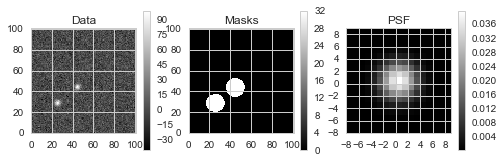

In [102]:
from lsst.meas.base.tests import TestDataset
#from meas_base_tests import TestDataset   ## my slightly modified version
import lsst.afw.geom as afwGeom

def makeStarImage_lsst(w=101, h=101, xc=[15.3], yc=[18.6], flux=[2500], psfSigma=2., noise=1.0, schema=None):
    bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(w-1, h-1))
    dataset = TestDataset(bbox, psfSigma=psfSigma, threshold=1.)
    for i in xrange(len(xc)):
        dataset.addSource(flux=flux[i], centroid=afwGeom.Point2D(xc[i], yc[i]))
    if schema is None:
        schema = TestDataset.makeMinimalSchema()
    exposure, catalog = dataset.realize(noise=noise, schema=schema)
    return exposure, catalog

## Don't put sources too close to the edge!
## Test it on blended sources...
#exposure, catalog = makeStarImage_lsst(xc=[15.3,34.2], yc=[18.6, 33.5], flux=[2500., 2345.], noise=10.)
exposure, catalog = makeStarImage_lsst(xc=[25.3,44.2], yc=[28.6, 43.5], flux=[2500., 2345.], noise=10.)
displayExposure(exposure, showPsf=True)
print exposure.getMaskedImage().getArrays()[2].mean()
print exposure.getPsf().computeShape().getDeterminantRadius()
print exposure.getMaskedImage().getArrays()[0].sum()

(101, 101)
200.0
100.0
100.0


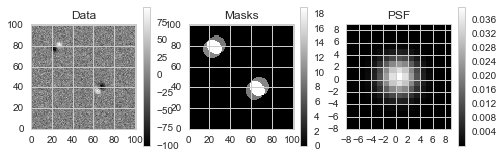

In [139]:
def makeDipoleImage_lsst(w=101, h=101, xcenPos=[27.], ycenPos=[25.], xcenNeg=[23.], ycenNeg=[25.], psfSigma=2., 
                         flux=[30000.], fluxNeg=[None], noise=10.):
    
    posImage, posCatalog = makeStarImage_lsst(w, h, xcenPos, ycenPos, flux=flux, psfSigma=psfSigma, 
                                              noise=noise)
    if fluxNeg is None:
        fluxNeg = flux
    negImage, negCatalog = makeStarImage_lsst(w, h, xcenNeg, ycenNeg, flux=fluxNeg, psfSigma=psfSigma, 
                                              noise=noise)
    
    dipole = posImage.clone()
    di = dipole.getMaskedImage()
    di -= negImage.getMaskedImage()
    
    ## Carry through pos/neg detection masks to new planes in diffim image
    dm = di.getMask()
    posDetectedBits = posImage.getMaskedImage().getMask().getArray() == dm.getPlaneBitMask("DETECTED")
    negDetectedBits = negImage.getMaskedImage().getMask().getArray() == dm.getPlaneBitMask("DETECTED")
    pos_det = dm.addMaskPlane("DETECTED_POS") ## new mask plane -- this is different from "DETECTED"
    neg_det = dm.addMaskPlane("DETECTED_NEG") ## new mask plane -- this is different from "DETECTED_NEGATIVE"
    dma = dm.getArray()
    dma[:,:] = posDetectedBits * pos_det + negDetectedBits * neg_det  ## set the two custom mask planes to these masks
    return dipole, (posImage, posCatalog), (negImage, negCatalog)

npa = np.array
xc = npa([65.3, 24.2])
yc = npa([38.6, 78.5])
flux = npa([2500., 2345.])
dipole, (posImage, posCatalog), (negImage, negCatalog) = \
    makeDipoleImage_lsst(xcenPos=xc + npa([-2., +2.]), ycenPos=yc + npa([-2., +2.]), 
                         xcenNeg=xc - npa([-2., +2.]), ycenNeg=yc - npa([-2., +2.]), flux=flux, fluxNeg=flux)
displayExposure(dipole, showPsf=True)
print dipole.getMaskedImage().getArrays()[0].shape
print dipole.getMaskedImage().getArrays()[2].mean()
print posImage.getMaskedImage().getArrays()[2].mean()
print negImage.getMaskedImage().getArrays()[2].mean()

exposure = dipole

Code taken from Jim Bosch's "measurement" bootcamp talk...

https://github.com/lsst-dm/Oct15_bootcamp/blob/measurement/measurement/new-plugin-1.ipynb

In [140]:
import lsst.meas.base
import lsst.pex.config
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender

In [141]:
# We have to initialize all tasks before using any of them:
# multiple tasks will write to the same Schema, and we can't create an output 
# catalog until we've finished defining that Schema.

# Start with a minimal schema - only the fields all SourceCatalogs need
schema = lsst.afw.table.SourceTable.makeMinimalSchema()

Detect sources in the pos- and neg- images separately. Already done above. Try deblending on them.

In [142]:
# Create and run a task for deblending (optional, but almost always a good idea). 
# Again, the task defines a few flag fields it will later fill. 
deblendTask = lsst.meas.deblender.SourceDeblendTask(schema=schema)

deblendTask.run(posImage, posCatalog, psf=posImage.getPsf())
deblendTask.run(negImage, negCatalog, psf=negImage.getPsf())

Detect positive and negative sources in the imDiff, then merge them (some code [noted] taken from `lsst/pipe/tasks/imageDifference.py`)

In [143]:
# Customize the detection task a bit (optional)
detectConfig = lsst.meas.algorithms.SourceDetectionConfig() 
detectConfig.returnOriginalFootprints = False # should be the default 
detectConfig.thresholdValue = 10 # only 10-sigma detections

## code from imageDifference.py:
detectConfig.thresholdPolarity = "both"
detectConfig.thresholdValue = 5.5
detectConfig.reEstimateBackground = False
detectConfig.thresholdType = "pixel_stdev"

# Create the detection task. We pass the schema so the task can declare a few flag fields
detectTask = lsst.meas.algorithms.SourceDetectionTask(config=detectConfig, schema=schema)

table = lsst.afw.table.SourceTable.make(schema)
detectResult = detectTask.run(table, exposure)
catalog = detectResult.sources
#results = detectTask.makeSourceCatalog(table, exposure, sigma=psfSigma)

deblendTask.run(exposure, catalog, psf=exposure.getPsf())

Now do the merge. Make sure to only do this once! If you need to re-run it, then re-run the 2 cells above as well.

In [144]:
print len(detectResult.sources), detectResult.fpSets.numPos, detectResult.fpSets.numNeg
fpSet = detectResult.fpSets.positive
fpSet.merge(detectResult.fpSets.negative, 2, 2, False)
sources = afwTable.SourceCatalog(table)
fpSet.makeSources(sources)
print type(fpSet), type(detectResult.sources), type(detectResult.fpSets.positive)

4 2 2
<class 'lsst.afw.detection.detectionLib.FootprintSet'> <class 'lsst.afw.table.tableLib.SourceCatalog'> <class 'lsst.afw.detection.detectionLib.FootprintSet'>


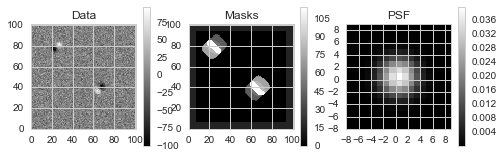

In [145]:
displayExposure(exposure, showPsf=True)

In [146]:
#xc = npa([15.3, 34.2])
#yc = npa([18.6, 33.5])

for s in sources:
    fp = s.getFootprint()
    print fp.getNpix()
    for pk in fp.getPeaks():
        print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx(), pk.getPeakValue()

476
FOOTPRINT CENTER: 36 63 39.8363189697
FOOTPRINT CENTER: 41 68 -42.1057052612
475
FOOTPRINT CENTER: 81 27 42.8737449646
FOOTPRINT CENTER: 76 22 -44.3646583557


## Example BoxFluxPlugin

In [147]:
class BoxFluxConfig(lsst.meas.base.SingleFramePluginConfig):
    
    width = lsst.pex.config.Field(
        dtype=int, default=30,
        doc="approximate width of rectangular aperture"
    )

    height = lsst.pex.config.Field(
        dtype=int, default=30,
        doc="approximate height of rectangular aperture"
    )
    
class BoxFluxTransform(lsst.meas.base.FluxTransform):

    def __init__(self, config, name, mapper):
        lsst.meas.base.FluxTransform.__init__(self, name, mapper)
        mapper.addMapping(mapper.getInputSchema().find(name + "_flag_edge").key)

        
## @lsst.meas.base.deregister() doesn't exist, so let's do this first...        
try:    
    del lsst.meas.base.SingleFramePlugin.registry._dict["ext_BoxFlux"]
except:
    pass

@lsst.meas.base.register("ext_BoxFlux")
class BoxFluxPlugin(lsst.meas.base.SingleFramePlugin):

    ConfigClass = BoxFluxConfig
    
    FAILURE_EDGE = 1

    @classmethod
    def getExecutionOrder(cls):
        return cls.FLUX_ORDER

    @classmethod
    def getTransformClass(cls):
        return BoxFluxTransform
    
    def __init__(self, config, name, schema, metadata):
        lsst.meas.base.SingleFramePlugin.__init__(self, config, name, schema, metadata)

        # Get a FunctorKey that can quickly look up the "blessed" centroid value.
        self.centroidKey = lsst.afw.table.Point2DKey(schema["slot_Centroid"])

        # Add some fields for our outputs, and save their Keys.
        doc = "flux in a {0.width} x {0.height} rectangle".format(self.config)
        self.fluxKey = schema.addField(
            schema.join(name, "flux"), type=float, units="dn", doc=doc
        )
        self.fluxSigmaKey = schema.addField(
            schema.join(name, "fluxSigma"), type=float, units="dn",
            doc="1-sigma uncertainty for BoxFlux"
        )
        self.flagKey = schema.addField(
            schema.join(name, "flag"), type="Flag",
            doc="general failure flag for BoxFlux"
        )
        self.edgeFlagKey = schema.addField(
            schema.join(name, "flag", "edge"), type="Flag",
            doc="flag set when rectangle used by BoxFlux doesn't fit in the image"
        )
    
    def measure(self, measRecord, exposure):

        centroid = measRecord.get(self.centroidKey)
    
        # Create a single-pixel box
        point = lsst.afw.geom.Point2I(centroid)
        box = lsst.afw.geom.Box2I(point, point)

        # Grow the box in the desired size
        box.grow(lsst.afw.geom.Extent2I(self.config.width // 2, self.config.height // 2))

        # Horrible syntax to create a subimage.  Can't use [] because it doesn't pay
        # attention to xy0 :-(
        try: 
            subMaskedImage = exposure.getMaskedImage().Factory(
                exposure.getMaskedImage(),
                box,
                lsst.afw.image.PARENT
            )
        except lsst.pex.exceptions.LengthError as err:
            raise lsst.meas.base.MeasurementError(str(err), self.FAILURE_EDGE)

        # compute the flux by extracting and summing NumPy arrays.
        flux = subMaskedImage.getImage().getArray().sum()
        fluxSigma = subMaskedImage.getVariance().getArray().sum()**0.5
        
        print flux, fluxSigma

        measRecord[self.fluxKey] = flux
        measRecord[self.fluxSigmaKey] = fluxSigma
        
    def fail(self, measRecord, error=None):
        measRecord.set(self.flagKey, True)
        if error is not None:
            assert error.getFlagBit() == self.FAILURE_EDGE
            measRecord.set(self.edgeFlagKey, True)

Try using existing ip_diffim dipole measurement task.

F**ck it, let's just write our plugin.

In [210]:
from collections import namedtuple
resultsOutput = namedtuple('resultsOutput', 
        #'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')
        'psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')

def dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, fluxNeg=None, 
               **kwargs):
    """
    Dipole based on image's psf. Image is passed as kwargs['diffim']
    dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, fluxNeg)
    """
    #diffim = kwargs.get('diffim')
    psf = kwargs.get('psf') #diffim.getPsf()
    rel_weight = kwargs.get('rel_weight')
    fp = kwargs.get('footprint')
    bbox = fp.getBBox()
    
    if fluxNeg is None:
        fluxNeg = flux
    
    p_pos = psf.computeImage(afwGeom.Point2D(xcenPos, ycenPos)).convertF()
    p_pos_sum = np.sum(p_pos.getArray())
    p_pos *= (flux/p_pos_sum)
    p_neg = psf.computeImage(afwGeom.Point2D(xcenNeg, ycenNeg)).convertF()
    p_neg_sum = np.sum(p_neg.getArray())
    p_neg *= (fluxNeg/p_neg_sum)
    
    pos_box = p_pos.getBBox()
    neg_box = p_neg.getBBox()
    
    ## Clip the PSF image bounding boxes to fall within the footprint bounding box
    pos_box.clip(bbox)
    neg_box.clip(bbox)

    ## Then actually crop the psf images. 
    ## Usually not necessary, but if the dipole is near the edge of the image...
    ## Would be nice if we could compare original pos_box with clipped pos_box and see if it actually was clipped.
    p_pos = afwImage.ImageF(p_pos, pos_box, afwImage.PARENT)
    p_neg = afwImage.ImageF(p_neg, neg_box, afwImage.PARENT)

    posIm = afwImage.ImageF(bbox)
    tmpSubim = afwImage.ImageF(posIm, pos_box, afwImage.PARENT)
    tmpSubim += p_pos

    negIm = afwImage.ImageF(bbox)
    tmpSubim = afwImage.ImageF(negIm, neg_box, afwImage.PARENT)
    tmpSubim += p_neg

    diffIm = afwImage.ImageF(bbox)
    #tmpSubim = afwImage.ImageF(diffIm, pos_box, afwImage.PARENT)
    #tmpSubim += p_pos
    #tmpSubim = afwImage.ImageF(diffIm, neg_box, afwImage.PARENT)
    #tmpSubim -= p_neg
    diffIm += posIm
    diffIm -= negIm

    zout = diffIm.getArray()
    if rel_weight > 0.:
        zout = np.append([zout], [posIm.getArray(), negIm.getArray()], axis=0)
        
    return zout

def fitDipole(exposure, source, tol=1e-7, rel_weight=0.1, centroidRangeInSigma=5., verbose=False, display=False):
    """fitDipole(z, psfWidth=2., verbose=False, display=False, cenPos=None, cenNeg=None))
        Starting centroids may be provided as tuple/array coordinates of centroids of positive and negative lobes.
        If these are None, then assume they are the max/min of the stamp.
    """
    posImage = negImage = None
    if rel_weight > 0.:
        diffim, posImage, negImage = exposure    ## assume exposure is actually a tuple here.
    else:
        diffim = exposure
        #posImage = exposure
        #negImage = exposure
    
    fp = source.getFootprint()
    box = fp.getBBox()
    extent = (box.getBeginX(), box.getEndX(), box.getBeginY(), box.getEndY())
    subim = diffim.getMaskedImage().Factory(
                    diffim.getMaskedImage(), box, lsst.afw.image.PARENT)
    
    #z = diffim.getMaskedImage().getArrays()[0] ## allow passing of just diffim (1-length tuple)
    z = subim.getArrays()[0] ## allow passing of just diffim (1-length tuple)
    if rel_weight > 0.:
        posSubim = posImage.getMaskedImage().Factory(
                        posImage.getMaskedImage(), box, lsst.afw.image.PARENT)
        negSubim = negImage.getMaskedImage().Factory(
                        negImage.getMaskedImage(), box, lsst.afw.image.PARENT)
        z = np.append([z], [posSubim.getArrays()[0], 
                        negSubim.getArrays()[0]], axis=0)
        
    #w, h = diffim.getWidth(), diffim.getHeight()
    psfSigma = diffim.getPsf().computeShape().getDeterminantRadius()
            
    gmod = lmfit.Model(dipoleFunc, verbose=verbose)

    pks = fp.getPeaks()
    cenPos = pks[0].getF() ##np.array(pks[0].getF()) #[::-1]  ## need to switch x,y ?? No.
    cenNeg = pks[1].getF() ##np.array(pks[1].getF()) #[::-1]  ## assume pos peak is first?
    #print cenPos, cenNeg

    ## For close/faint dipoles the starting locs (min/max) might be way off, let's help them a bit.
    ## First assume dipole is not separated by more than 5*psfSigma. 
    centroidRange = psfSigma * centroidRangeInSigma

    ## parameter hints/constraints: https://lmfit.github.io/lmfit-py/model.html#model-param-hints-section
    gmod.set_param_hint('xcenPos', value=cenPos[0], min=cenPos[0]-centroidRange, max=cenPos[0]+centroidRange)
    gmod.set_param_hint('ycenPos', value=cenPos[1], min=cenPos[1]-centroidRange, max=cenPos[1]+centroidRange)
    gmod.set_param_hint('xcenNeg', value=cenNeg[0], min=cenNeg[0]-centroidRange, max=cenNeg[0]+centroidRange)
    gmod.set_param_hint('ycenNeg', value=cenNeg[1], min=cenNeg[1]-centroidRange, max=cenNeg[1]+centroidRange)

    ## Estimate starting flux. This strongly affects runtime performance so we want to make it close.
    ## TBD: if this actually is what we end up using, then we can't sum over the entier image. 
    ## Need to use a localized region/footprint or bbox and know the local background from the image?.
    ## DONE, now we are just using the footprint bounding box.
    if rel_weight > 0.:
        startingFlux = (z[1,:] - np.median(z[1,:])).sum()   ## use the pos. image; subtract the background
    else:
        startingFlux = (np.abs(z) - np.median(z)).sum() / 2.  ## use the dipole for an estimate. Remove the background

    gmod.set_param_hint('flux', value=startingFlux, min=0.1) #, max=startingFlux * 2.)  ## TBD: set max. flux limit? 
    gmod.set_param_hint('fluxNeg', value=startingFlux, min=0.1) #, max=startingFlux * 2.)  ## TBD: set max. flux limit? 
    
    ## Fixed parameters (dont fit for them):
    #gmod.set_param_hint('exposure', value=exposure, vary=False)

    #y, x = np.mgrid[extent[0]:extent[1], extent[2]:extent[3]] #np.mgrid[:w, :h]
    #in_x = np.array([x, y])
    ## pass the dipole image's bounding box (extent) as input (lmfit makes sure it's an array)
    ## Note it's currently not used in dipoleFunc()
    in_x = np.array(extent)
    
    ## TBD: weight the data by 1/variance
    ## Weight the "pre-subtraction" planes by rel_weight (relative to the actual diffim plane)
    if rel_weight > 0.:
        weights = np.array([np.ones_like(z[0,:]), np.ones_like(z[0,:])*rel_weight, np.ones_like(z[0,:])*rel_weight])
    else:
        weights = 1.
    
    result = gmod.fit(z, weights=weights,
                      x=in_x, flux=startingFlux, fluxNeg=startingFlux, 
                      xcenPos=cenPos[0], ycenPos=cenPos[1], 
                      xcenNeg=cenNeg[0], ycenNeg=cenNeg[1], verbose=verbose, #) #, sig1=1., sig2=2.)
                      ## default fit method -- levenberg-marquardt ('leastsq')
                      fit_kws={'ftol':tol, 'xtol':tol, 'gtol':tol},
                      #diffim=subim, #diffim, 
                      psf=diffim.getPsf(),
                      rel_weight=rel_weight,
                      footprint=fp
                     )  
                      #method='nelder',
                      #fit_kws={'tol':tol})
    
    if verbose: 
        print result.fit_report(show_correl=False) 
        ## This is how to get confidence intervals out; 
        ##    see here: https://lmfit.github.io/lmfit-py/confidence.html and 
        ##    here: http://cars9.uchicago.edu/software/python/lmfit/model.html
        ## Note this calc takes a long time (longer than the fit!)
        print result.ci_report()

    if display:
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 3, 1)
        if rel_weight > 0.:
            display2dArray(z[0,:], 'Data', True, extent=extent)
        else:
            display2dArray(z, 'Data', True, extent=extent)
        plt.subplot(1, 3, 2)
        if rel_weight > 0.:
            display2dArray(result.best_fit[0,:], 'Model', True, extent=extent)
        else:
            display2dArray(result.best_fit, 'Model', True, extent=extent)
        plt.subplot(1, 3, 3)
        if rel_weight > 0.:
            display2dArray(z[0,:] - result.best_fit[0,:], 'Residual', True, extent=extent)
        else:
            display2dArray(z - result.best_fit, 'Residual', True, extent=extent)

    return result

def fitDipole_new(exposure, source, tol=1e-7, rel_weight=0.1, return_fitObj=False, 
                  centroidRangeInSigma=5., verbose=False, display=False):

    result = fitDipole(exposure, source=source, rel_weight=rel_weight, tol=tol, 
                       centroidRangeInSigma=centroidRangeInSigma, verbose=verbose, display=display)

    #rotAngRad = rotAngle / 180. * np.pi
    #xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    #xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    results = result.best_values
    
    centroid = ((results['xcenPos']+results['xcenNeg'])/2., (results['ycenPos']+results['ycenNeg'])/2.)
    dx, dy = results['xcenPos']-results['xcenNeg'], results['ycenPos']-results['ycenNeg']
    angle = np.arctan2(dy, dx) / np.pi * 180.   ## convert to degrees, or keep as rad?

    fluxVal, fluxErr = result.params['flux'].value, result.params['flux'].stderr
    fluxValNeg, fluxErrNeg = result.params['fluxNeg'].value, result.params['fluxNeg'].stderr
    signalToNoise = np.sqrt((fluxVal/fluxErr)**2 + (fluxValNeg/fluxErrNeg)**2) ## This is from DipoleAnalysis code
        
    out = resultsOutput(##xxc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
                        results['xcenPos'], results['ycenPos'], results['xcenNeg'], results['ycenNeg'],
                        fluxVal, -fluxValNeg, centroid[0], centroid[1], angle, signalToNoise)

    if not return_fitObj: 
        return out #.best_values
    return out, result

Box2I((52, 25), (79, 53)) 476
FOOTPRINT CENTER: 36 63 39.8363189697
FOOTPRINT CENTER: 41 68 -42.1057052612
Box2I((11, 65), (38, 92)) 475
FOOTPRINT CENTER: 81 27 42.8737449646
FOOTPRINT CENTER: 76 22 -44.3646583557
 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "fluxNeg"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "fluxNeg"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 2436
    # variables        = 6
    chi-square         = 151295.400
    reduced chi-square = 62.261
[[Variables]]
    xcenPos:   63.2787486 +/- 0.075574 (0.12%) (init= 63)
    ycenPos:   36.5235943 +/- 0.075237 (0.21%) (init= 36)
    xcenNeg:   67.3874076 +/- 0.071977 (0.11

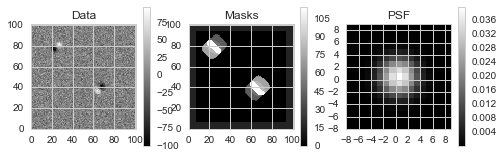

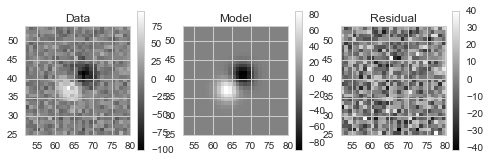

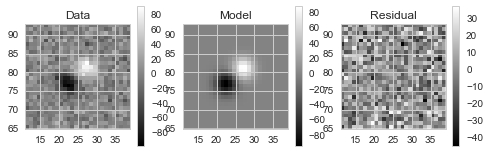

In [211]:
for s in sources:
    fp = s.getFootprint()
    print fp.getBBox(), fp.getNpix()
    for pk in fp.getPeaks():
        print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx(), pk.getPeakValue()

displayExposure(exposure, showPsf=True)

verbose = True
for s in sources:
    result = fitDipole_new((dipole, posImage, negImage), s, rel_weight=0.05, verbose=verbose, display=True)
    verbose = False
    
#%timeit fitDipole_new((dipole, posImage, negImage), s, rel_weight=0., verbose=False, display=False)
#%timeit fitDipole_new(dipole, s, rel_weight=0., verbose=False, display=False)

print result

 - Adding parameter for hint "xcenPos"
 - Adding parameter for hint "ycenPos"
 - Adding parameter for hint "xcenNeg"
 - Adding parameter for hint "ycenNeg"
 - Adding parameter for hint "flux"
 - Adding parameter for hint "fluxNeg"
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
 - Adding parameter "fluxNeg"
[[Model]]
    Model(dipoleFunc)
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 812
    # variables        = 6
    chi-square         = 150884.769
    reduced chi-square = 187.202
[[Variables]]
    xcenPos:   63.2786117 +/- 0.131328 (0.21%) (init= 63)
    ycenPos:   36.5235084 +/- 0.130752 (0.36%) (init= 36)
    xcenNeg:   67.3876521 +/- 0.125052 (0.19%) (init= 68)
    ycenNeg:   40.6123850 +/- 0.124454 (0.31%) (init= 41)
    flux:      2237.36773 +/- 102.0884 (4.56%) (init= 6065.349)
    fluxNeg:   2346.13260 +/- 102.1120 (4.35%) (init= 6065.349)

            9

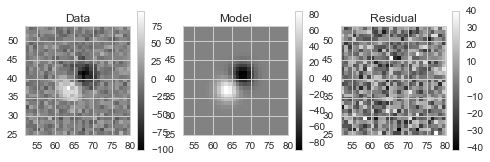

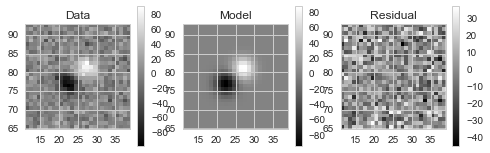

In [212]:
## Need to be able to do it without pre-subtracted images
verbose = True
for s in sources:
    result = fitDipole_new(dipole, s, verbose=verbose, rel_weight=0., display=True)
    verbose = False
    
print result

%timeit fitDipole_new((dipole, posImage, negImage), sources[1], rel_weight=0.05, verbose=False, display=False)
%timeit fitDipole_new(dipole, sources[1], rel_weight=0., verbose=False, display=False)

## Make the DipoleFitPlugin !!!

In [193]:
class DipoleFitConfig(lsst.meas.base.SingleFramePluginConfig):
    
    centroidRange = lsst.pex.config.Field(
        dtype=float, default=5.,
        doc="assume dipole is not separated by more than centroidRange*psfSigma"
    )

    relWeight = lsst.pex.config.Field(
        dtype=float, default=0., ##0.05,
        doc="relative weighting of pre-subtraction images"
    )

    tolerance = lsst.pex.config.Field(
        dtype=float, default=1e-7,
        doc="fit tolerance"
    )
    
class DipoleFitTransform(lsst.meas.base.FluxTransform):

    def __init__(self, config, name, mapper):
        lsst.meas.base.FluxTransform.__init__(self, name, mapper)
        mapper.addMapping(mapper.getInputSchema().find(name + "_flag_edge").key)

        
## @lsst.meas.base.deregister() doesn't exist, so let's do this first...        
try:    
    del lsst.meas.base.SingleFramePlugin.registry._dict["ext_DipoleFit"]
except:
    pass

@lsst.meas.base.register("ext_DipoleFit")
class DipoleFitPlugin(lsst.meas.base.SingleFramePlugin):

    ConfigClass = DipoleFitConfig
    
    FAILURE_EDGE = 1

    @classmethod
    def getExecutionOrder(cls):
        return cls.FLUX_ORDER    ## TBD: flux order or centroid order? Or separate them out?

    @classmethod
    def getTransformClass(cls):
        return DipoleFitTransform
    
    def _setupSchema(self, config, name, schema, metadata):
        # Get a FunctorKey that can quickly look up the "blessed" centroid value.
        self.centroidKey = lsst.afw.table.Point2DKey(schema["slot_Centroid"])

        # Add some fields for our outputs, and save their Keys.
        # Use setAttr() to programmatically set the pos/neg named attributes to values, e.g. 
        # self.posCentroidKeyX = 'ext_DipoleFit_pos_centroid_x'
        
        for pos_neg in ['pos', 'neg']:

            key = schema.addField(
                schema.join(name, pos_neg, "flux"), type=float, units="dn", 
                doc="Dipole {0} lobe flux".format(pos_neg)
            )
            setattr(self, ''.join((pos_neg, 'FluxKey')), key)
            
            key = schema.addField(
                schema.join(name, pos_neg, "fluxSigma"), type=float, units="pixels",
                doc="1-sigma uncertainty for {0} dipole flux".format(pos_neg)
            )
            setattr(self, ''.join((pos_neg, 'FluxSigmaKey')), key)

            for x_y in ['x', 'y']:
                key = schema.addField(
                    schema.join(name, pos_neg, "centroid", x_y), type=float, units="pixels", 
                    doc="Dipole {0} lobe centroid".format(pos_neg)
                )
                setattr(self, ''.join((pos_neg, 'CentroidKey', x_y.upper())), key)

        for x_y in ['x', 'y']:
            key = schema.addField(
                schema.join(name, "centroid", x_y), type=float, units="pixels", 
                doc="Dipole centroid"
            )
            setattr(self, ''.join(('CentroidKey', x_y.upper())), key)

        self.orientationKey = schema.addField(
            schema.join(name, "orientation"), type=float, units="deg", 
            doc="Dipole orientation"
        )

        self.flagKey = schema.addField(
            schema.join(name, "flag"), type="Flag",
            doc="general failure flag for dipole fit"
        )

        self.edgeFlagKey = schema.addField(
            schema.join(name, "flag", "edge"), type="Flag",
            doc="flag set when rectangle used by dipole doesn't fit in the image"
        )
        
    def __init__(self, config, name, schema, metadata):
        lsst.meas.base.SingleFramePlugin.__init__(self, config, name, schema, metadata)
        
        self._setupSchema(config, name, schema, metadata)

    def measure(self, measRecord, exposure):
        
        result = fitDipole_new(exposure, measRecord, rel_weight=self.config.relWeight, 
                               tol=self.config.tolerance, centroidRangeInSigma=self.config.centroidRange,
                               verbose=False, display=False)
        
        ## TBD: add chi2, coord/flux uncertainties

        #psfFitPosCentroidX, psfFitPosCentroidY, psfFitNegCentroidX, psfFitNegCentroidY, psfFitPosFlux, 
        #psfFitNegFlux, psfFitCentroidX, psfFitCentroidY, psfFitOrientation, psfFitSignaltoNoise
        print result
        
        measRecord[self.posFluxKey] = result.psfFitPosFlux
        measRecord[self.posFluxSigmaKey] = result.psfFitSignaltoNoise   ## to be changed to actual sigma
        measRecord[self.posCentroidKeyX] = result.psfFitPosCentroidX
        measRecord[self.posCentroidKeyY] = result.psfFitPosCentroidY

        measRecord[self.negFluxKey] = result.psfFitNegFlux
        measRecord[self.negFluxSigmaKey] = result.psfFitSignaltoNoise
        measRecord[self.negCentroidKeyX] = result.psfFitNegCentroidX
        measRecord[self.negCentroidKeyY] = result.psfFitNegCentroidY
        
        measRecord[self.orientationKey] = result.psfFitOrientation
        measRecord[self.centroidKeyX] = (result.psfFitPosCentroidX + result.psfFitNegCentroidX)/2.
        measRecord[self.centroidKeyY] = (result.psfFitPosCentroidY + result.psfFitNegCentroidY)/2.
        
    def fail(self, measRecord, error=None):
        measRecord.set(self.flagKey, True)
        if error is not None:
            assert error.getFlagBit() == self.FAILURE_EDGE
            measRecord.set(self.edgeFlagKey, True)

In [194]:
measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()

# Modify the set of active plugins ('.names' behaves like a Python set)
#measureConfig.plugins.names.remove("base_GaussianCentroid")

# Enable some plugins - import the Python module first to make them available
measureConfig.plugins.names |= ["modelfit_ShapeletPsfApprox", "modelfit_CModel"]

# Change which plugin's output we "bless" as the "Model Flux"
measureConfig.slots.modelFlux = "modelfit_CModel"

# Modify the internal configuration of one of the plugins
measureConfig.plugins["base_ClassificationExtendedness"].fluxRatio = 0.985

# Disable aperture correction, which requires having an ApCorrMap attached to
# the Exposure (it'll warn if it's not present and we don't explicitly disable it). 
measureConfig.doApplyApCorr = "no"

In [195]:
#measureConfig = lsst.meas.base.SingleFrameMeasurementConfig()
measureConfig.plugins.names.add("ext_BoxFlux")

measureConfig.plugins.names.add("ext_DipoleFit")

# Actually create the Task. This initializes all the plugins and that defines the rest of the schema
measureTask = lsst.meas.base.SingleFrameMeasurementTask(config=measureConfig, schema=schema)

In [196]:
#exposure = lsst.afw.image.ExposureF("coadd.fits") 
table = lsst.afw.table.SourceTable.make(schema)
detectResult = detectTask.run(table, exposure)
catalog = detectResult.sources
deblendTask.run(exposure, catalog, psf=exposure.getPsf())
#measureTask.run(catalog, exposure)

Now we run it on the merged sources instead of the original (unmerged) catalog which is what we ran it on above.

In [197]:
print len(detectResult.sources), detectResult.fpSets.numPos, detectResult.fpSets.numNeg
fpSet = detectResult.fpSets.positive
fpSet.merge(detectResult.fpSets.negative, 2, 2, False)
sources = afwTable.SourceCatalog(table)
fpSet.makeSources(sources)
print type(fpSet), type(detectResult.sources), type(detectResult.fpSets.positive), type(sources), type(catalog)

4 2 2
<class 'lsst.afw.detection.detectionLib.FootprintSet'> <class 'lsst.afw.table.tableLib.SourceCatalog'> <class 'lsst.afw.detection.detectionLib.FootprintSet'> <class 'lsst.afw.table.tableLib.SourceCatalog'> <class 'lsst.afw.table.tableLib.SourceCatalog'>


In [198]:
measureTask.run(sources, exposure)

BOX: 63 36
-702.355 438.406204336
resultsOutput(psfFitPosCentroidX=63.278611752387235, psfFitPosCentroidY=36.523508447053132, psfFitNegCentroidX=67.387652145849685, psfFitNegCentroidY=40.612385071603995, psfFitPosFlux=2237.3677362087751, psfFitNegFlux=-2346.1326065540075, psfFitCentroidX=65.333131949118467, psfFitCentroidY=38.567946759328564, psfFitOrientation=-135.1409256187188, psfFitSignaltoNoise=31.752304727989255)
BOX: 27 81
788.578 438.406204336
resultsOutput(psfFitPosCentroidX=26.51545929190641, psfFitPosCentroidY=80.564866365829801, psfFitNegCentroidX=21.899579807816938, psfFitNegCentroidY=76.509637143177315, psfFitPosFlux=2344.4074219638219, psfFitNegFlux=-2446.0777459592173, psfFitCentroidX=24.207519549861672, psfFitCentroidY=78.537251754503558, psfFitOrientation=41.300560531818341, psfFitSignaltoNoise=33.063073299069778)


Compare to input:
```
# xc = npa([65.3, 24.2])
# yc = npa([38.6, 78.5])
# flux = npa([2500., 2345.])
```
and output directly from `fitDipole_new()`:
```
resultsOutput(psfFitPosCentroidX=22.325779127112224, psfFitPosCentroidY=76.540552742891862, psfFitNegCentroidX=26.289575870428855, psfFitNegCentroidY=80.513130645933899, psfFitPosFlux=2252.1645078687548, psfFitNegFlux=-2315.713346564979, psfFitCentroidX=24.307677498770538, psfFitCentroidY=78.52684169441288, psfFitOrientation=-134.9366054138566, psfFitSignaltoNoise=50.016421691923441)
```

In [199]:
print measureConfig.plugins.names

['base_CircularApertureFlux', 'ext_BoxFlux', 'base_NaiveCentroid', 'base_PixelFlags', 'base_SkyCoord', 'base_PsfFlux', 'modelfit_CModel', 'base_GaussianCentroid', 'base_SdssCentroid', 'base_Variance', 'modelfit_ShapeletPsfApprox', 'base_GaussianFlux', 'ext_DipoleFit', 'base_SdssShape', 'base_ClassificationExtendedness']


In [200]:
for r1 in sources: #, r2 in zip(catalog, transformedCatalog):
    print r1.extract("ext_GaussianCentroid*") #, r2.extract("ext_BoxFlux*")

{}
{}


In [201]:
for r1 in sources: #, r2 in zip(catalog, transformedCatalog):
    print r1.extract("ext_BoxFlux*") #, r2.extract("ext_BoxFlux*")

{'ext_BoxFlux_flux': -702.3547973632812, 'ext_BoxFlux_fluxSigma': 438.4062043356595, 'ext_BoxFlux_flag': False, 'ext_BoxFlux_flag_edge': False}
{'ext_BoxFlux_flux': 788.57763671875, 'ext_BoxFlux_fluxSigma': 438.4062043356595, 'ext_BoxFlux_flag': False, 'ext_BoxFlux_flag_edge': False}


In [202]:
for r1 in sources: #, r2 in zip(catalog, transformedCatalog):
    print r1.extract("ext_DipoleFit*") #, r2.extract("ext_BoxFlux*")

{'ext_DipoleFit_pos_centroid_y': 36.52350844705313, 'ext_DipoleFit_pos_centroid_x': 63.278611752387235, 'ext_DipoleFit_centroid_x': nan, 'ext_DipoleFit_neg_fluxSigma': 31.752304727989255, 'ext_DipoleFit_orientation': -135.1409256187188, 'ext_DipoleFit_pos_fluxSigma': 31.752304727989255, 'ext_DipoleFit_flag_edge': False, 'ext_DipoleFit_neg_flux': -2346.1326065540075, 'ext_DipoleFit_neg_centroid_y': 40.612385071603995, 'ext_DipoleFit_neg_centroid_x': 67.38765214584969, 'ext_DipoleFit_flag': True, 'ext_DipoleFit_pos_flux': 2237.367736208775, 'ext_DipoleFit_centroid_y': nan}
{'ext_DipoleFit_pos_centroid_y': 80.5648663658298, 'ext_DipoleFit_pos_centroid_x': 26.51545929190641, 'ext_DipoleFit_centroid_x': nan, 'ext_DipoleFit_neg_fluxSigma': 33.06307329906978, 'ext_DipoleFit_orientation': 41.30056053181834, 'ext_DipoleFit_pos_fluxSigma': 33.06307329906978, 'ext_DipoleFit_flag_edge': False, 'ext_DipoleFit_neg_flux': -2446.0777459592173, 'ext_DipoleFit_neg_centroid_y': 76.50963714317732, 'ext_Di

In [203]:
print schema["slot_Centroid"]
print schema.asList()
centroidKey = lsst.afw.table.Point2DKey(schema["slot_Centroid"])
centroidKey

<lsst.afw.table.tableLib.SubSchema; proxy of <Swig Object of type 'lsst::afw::table::SubSchema *' at 0x121130c90> >
[SchemaItem(Key<L>(offset=0, nElements=1), Field['L'](name="id", doc="unique ID")), SchemaItem(Key<Angle>(offset=8, nElements=1), Field['Angle'](name="coord_ra", doc="position in ra/dec")), SchemaItem(Key<Angle>(offset=16, nElements=1), Field['Angle'](name="coord_dec", doc="position in ra/dec")), SchemaItem(Key<L>(offset=24, nElements=1), Field['L'](name="parent", doc="unique ID of parent source")), SchemaItem(Key<I>(offset=32, nElements=1), Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)")), SchemaItem(Key['Flag'](offset=40, bit=0), Field['Flag'](name="deblend_deblendedAsPsf", doc="Deblender thought this source looked like a PSF")), SchemaItem(Key<D>(offset=48, nElements=1), Field['D'](name="deblend_psfCenter_x", doc="If deblended-as-psf, the PSF centroid", units="pixels")), SchemaItem(Key<D>(offset=56, nElements=1), Field['D'](n

<lsst.afw.table.tableLib.Point2DKey; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::table::PointKey< double > > *' at 0x11db884b0> >